## Generative models, Discriminative models & Learning by eliminaton
A simple 1D demo

In [1]:
%pylab inline

from scipy.stats import norm, uniform
import scipy

from dists import *

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## two gaussians with similar means

means are at `-0.05,+0.05` std is 1

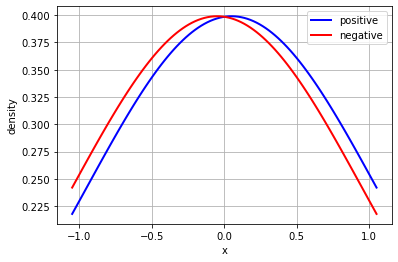

In [2]:
negative,positive=TwoNormals(_dist_from_0=0.05)

In [3]:
n=1000

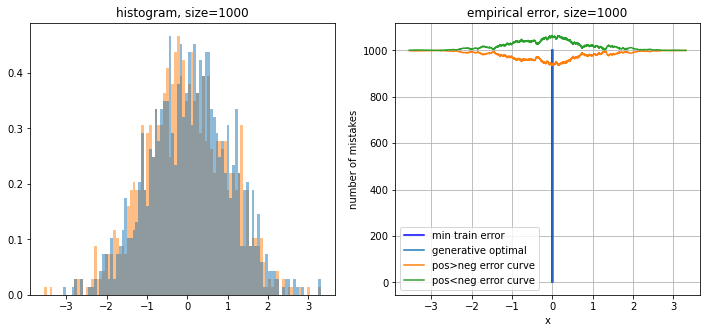

In [4]:
r_pos = positive.rvs(size=n)
r_neg = negative.rvs(size=n)

figure(figsize=[12,5])
subplot(1,2,1)
hist([r_pos,r_neg],density=True, histtype='stepfilled',bins=100, alpha=0.5);
title('histogram, size=%d'%n)
subplot(1,2,2)
thresholds_for_normals=mean(r_pos)+mean(r_neg)
error_curve(r_pos,r_neg,verticals=[('generative optimal',thresholds_for_normals)]) #_xlim=[-0.5,0.5]
title('empirical error, size=%d'%n);

## Two gaussians with distant means
Means are `-4,4` std is 1


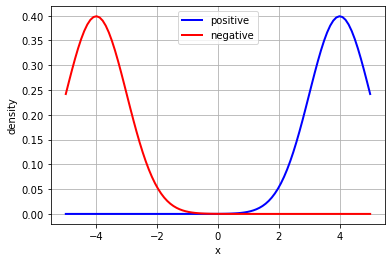

In [5]:
negative2,positive2=TwoNormals(_dist_from_0=4)

## When generative is better than min-error
Generative is better because distribution of `pos` is a reflection of dist of `neg` while the number of samples in `[-1,1]` is too small to guide the min-error.

If we consider the whole shape of the error funcion we see that `min train error` is very unlikely to be outside of `[-4,4]`


In [6]:
n=10

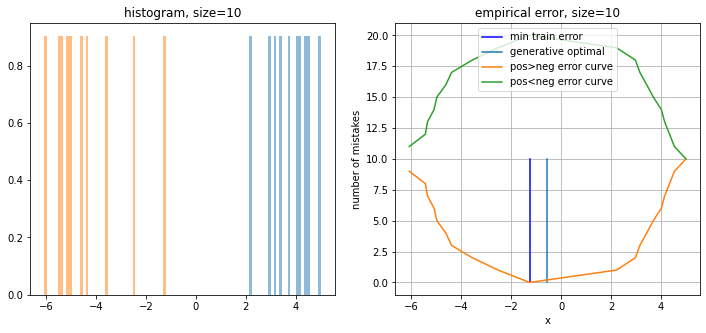

In [7]:
r_pos = positive2.rvs(size=n)
r_neg = negative2.rvs(size=n)

figure(figsize=[12,5])
subplot(1,2,1)
hist([r_pos,r_neg],density=True, histtype='stepfilled',bins=100, alpha=0.5);
title('histogram, size=%d'%n)
subplot(1,2,2)
thresholds_for_normals=mean(r_pos)+mean(r_neg)
error_curve(r_pos,r_neg,verticals=[('generative optimal',thresholds_for_normals)]) #_xlim=[-0.5,0.5]
title('empirical error, size=%d'%n);

## The large influence of a small assymetry

We use a mixture of the well separated normals with a uniform distribution. The mixing coefficients are `[90% normal 10% uniform]`

The uniform distribution is `[60% '+', 40% '-']` from -5 to 2 and switches to `[60% '-', 40% '+']` from 2 to 9.
Therefor the best threshold is at $x=2$.

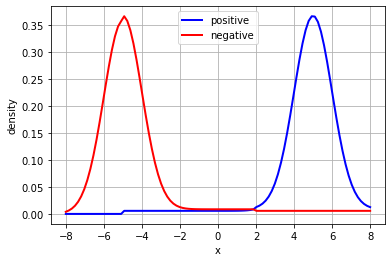

In [8]:
q=0.1
positive3=Mixture([(1-q,norm(loc=5)),(0.6*q,uniform(loc=2,scale=7)),(0.4*q,uniform(loc=-5,scale=7))])
negative3=Mixture([(1-q,norm(loc=-5)),(0.4*q,uniform(loc=2,scale=7)),(0.6*q,uniform(loc=-5,scale=7))])

x = np.linspace(-8,8,100)
plot(x, positive3.pdf(x), 'b-', lw=2, label='positive')
plot(x, negative3.pdf(x), 'r-', lw=2, label='negative')
xlabel('x')
ylabel('density')
grid()
legend();

In this case the distribution is an assymetric mixture, so even if the form of the distribution is known, it is not trivial to estimate the parameters.

The discriminative methods works well, but requires around 1000 training examples.

However even from 100 examples allow us to eliminate the thresholds outside of `[-4,4]`

In [50]:
n=10000

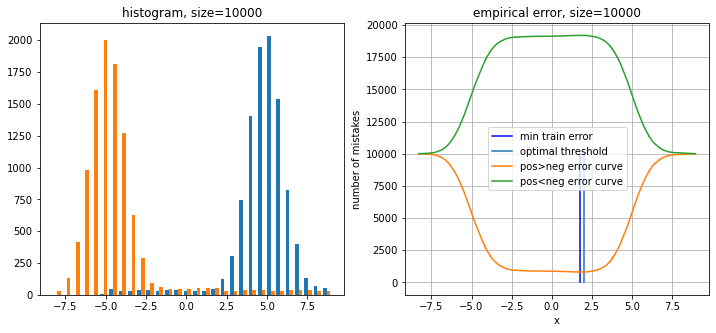

In [56]:
pos_s=positive3.rvs(size=n)
neg_s=negative3.rvs(size=n)

figure(figsize=[12,5])
subplot(1,2,2)
error_curve(pos_s,neg_s,verticals=[('optimal threshold',2)]);
title('empirical error, size=%d'%n)
subplot(1,2,1)
hist([pos_s,neg_s],bins=30);
title('histogram, size=%d'%n);

## three Gaussians

When one threshold is not enough

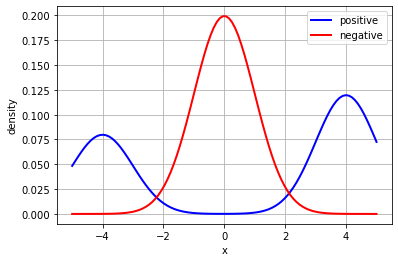

In [11]:
negative4,positive4=ThreeNormals(_dist_from_0=4,q=0.4)

In [57]:
n=20

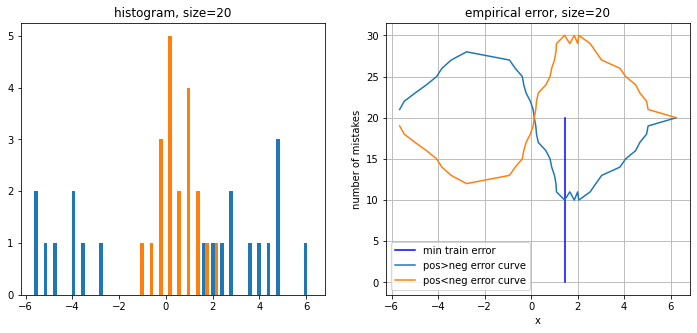

In [63]:
pos_s=positive4.rvs(size=n)
neg_s=negative4.rvs(size=n)

figure(figsize=[12,5])
subplot(1,2,2)
error_curve(pos_s,neg_s);
title('empirical error, size=%d'%n)
subplot(1,2,1)
hist([pos_s,neg_s],bins=30);
title('histogram, size=%d'%n);

### Down-weight the examples you go wrong
By downweighting the middle and right gaussians, we make it possible to find the other threshold.

This is the basic idea behind boosting.

(The reweighting here is just an example for intuition, it is not done using boosting).

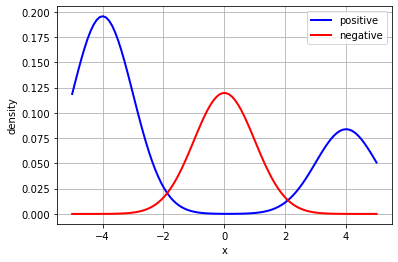

In [14]:
pos_ratio=0.7
pos_neg_ratio=0.7
negative5,positive5=ThreeNormals(_dist_from_0=4,q=pos_ratio,qq=pos_neg_ratio)

In [64]:
n=100

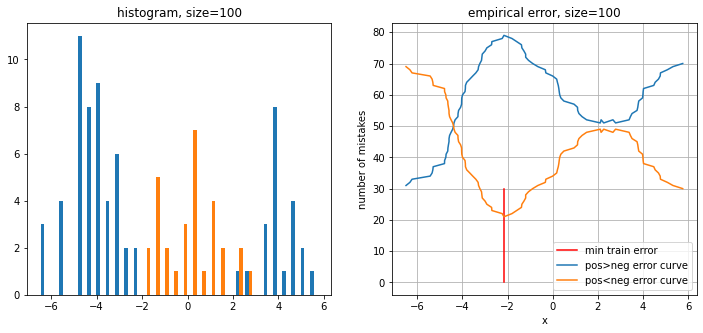

In [81]:
pos_s=positive5.rvs(size=int(n*pos_neg_ratio))
neg_s=negative5.rvs(size=int(n*(1-pos_neg_ratio)))

figure(figsize=[12,5])
subplot(1,2,2)
error_curve(pos_s,neg_s);
title('empirical error, size=%d'%n)
subplot(1,2,1)
hist([pos_s,neg_s],bins=30);
title('histogram, size=%d'%n);

## The End